In [54]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) #For displaying all the columns of dataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.model_selection import RandomizedSearchCV
import pickle
from dev.dev_run_v0 import load_data
import joblib



In [33]:
# df = pd.read_excel('./data/Data_Train.xlsx')

# Load the dataset from the defined path
df = load_data('Data_Train.xlsx') 

Loading data from data\Data_Train.xlsx...


In [34]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [35]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [36]:
def extract_date_hour(dataset, col):
    '''This function will create two columns containing Hours and Minutes
       extracted from `col` column and then dropped it from the dataset.'''
    
    dataset[col + '_hour'] = dataset[col].dt.hour
    dataset[col + '_minute'] = dataset[col].dt.minute
    dataset.drop(col, axis=1, inplace=True)
    
    return dataset

In [37]:
# Changing the datatype from object to datetime. 
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
df['Dep_Time']        = pd.to_datetime(df['Dep_Time'])
df['Arrival_Time']    = pd.to_datetime(df['Arrival_Time'])


#Extracting Day and Month.
df['Day']   = df['Date_of_Journey'].dt.day
df['Month'] = df['Date_of_Journey'].dt.month
df.drop('Date_of_Journey', axis=1, inplace=True)


#Extracting Hour and Minute.
df = extract_date_hour(df, 'Arrival_Time')
df = extract_date_hour(df, 'Dep_Time')

In [46]:

# Initialize LabelEncoder
encoder = LabelEncoder()

# Apply LabelEncoder to each categorical feature
categorical_cols = ['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [47]:
df

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day,Month,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_hour,Dep_Time_minute
0,3,0,5,18,2h 50m,4,8,3897,24,3,1,10,22,20
1,1,3,0,84,7h 25m,1,8,7662,1,5,13,15,5,50
2,4,2,1,118,19h 0m,1,8,13882,9,6,4,25,9,25
3,3,3,0,91,5h 25m,0,8,6218,12,5,23,30,18,5
4,3,0,5,29,4h 45m,0,8,13302,1,3,21,35,16,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,3,0,64,2h 30m,4,8,4107,9,4,22,25,19,55
10679,1,3,0,64,2h 35m,4,8,4145,27,4,23,20,20,45
10680,4,0,2,18,3h 0m,4,8,7229,27,4,11,20,8,20
10681,10,0,5,18,2h 40m,4,8,12648,1,3,14,10,11,30


In [48]:
duration = list(df['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' ')) == 2:
        pass
    else:
        if 'h' in duration[i]:
            duration[i]=duration[i] + ' 0m'
        else:
            duration[i]='0h '+ duration[i]

df['Duration'] = duration

In [50]:
df['Hour']   = df['Duration'].apply(lambda x:x.split(' ')[0][0:-1]).astype('int32')
df['Minute'] = df['Duration'].apply(lambda x:x.split(' ')[1][0:-1]).astype('int32')
df.drop('Duration', axis=1, inplace=True)

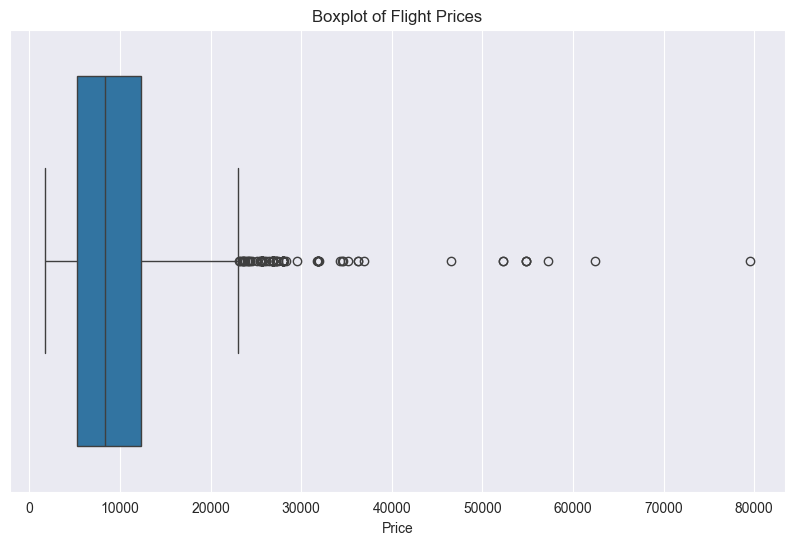

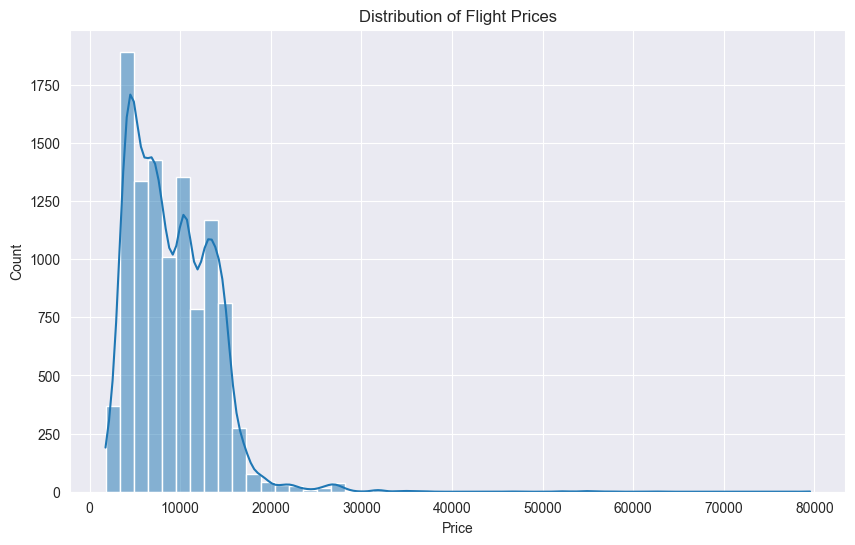

In [57]:
# Visualize the price distribution using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Price'])
plt.title("Boxplot of Flight Prices")
plt.show()

# Visualize the price distribution using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Distribution of Flight Prices")
plt.show()

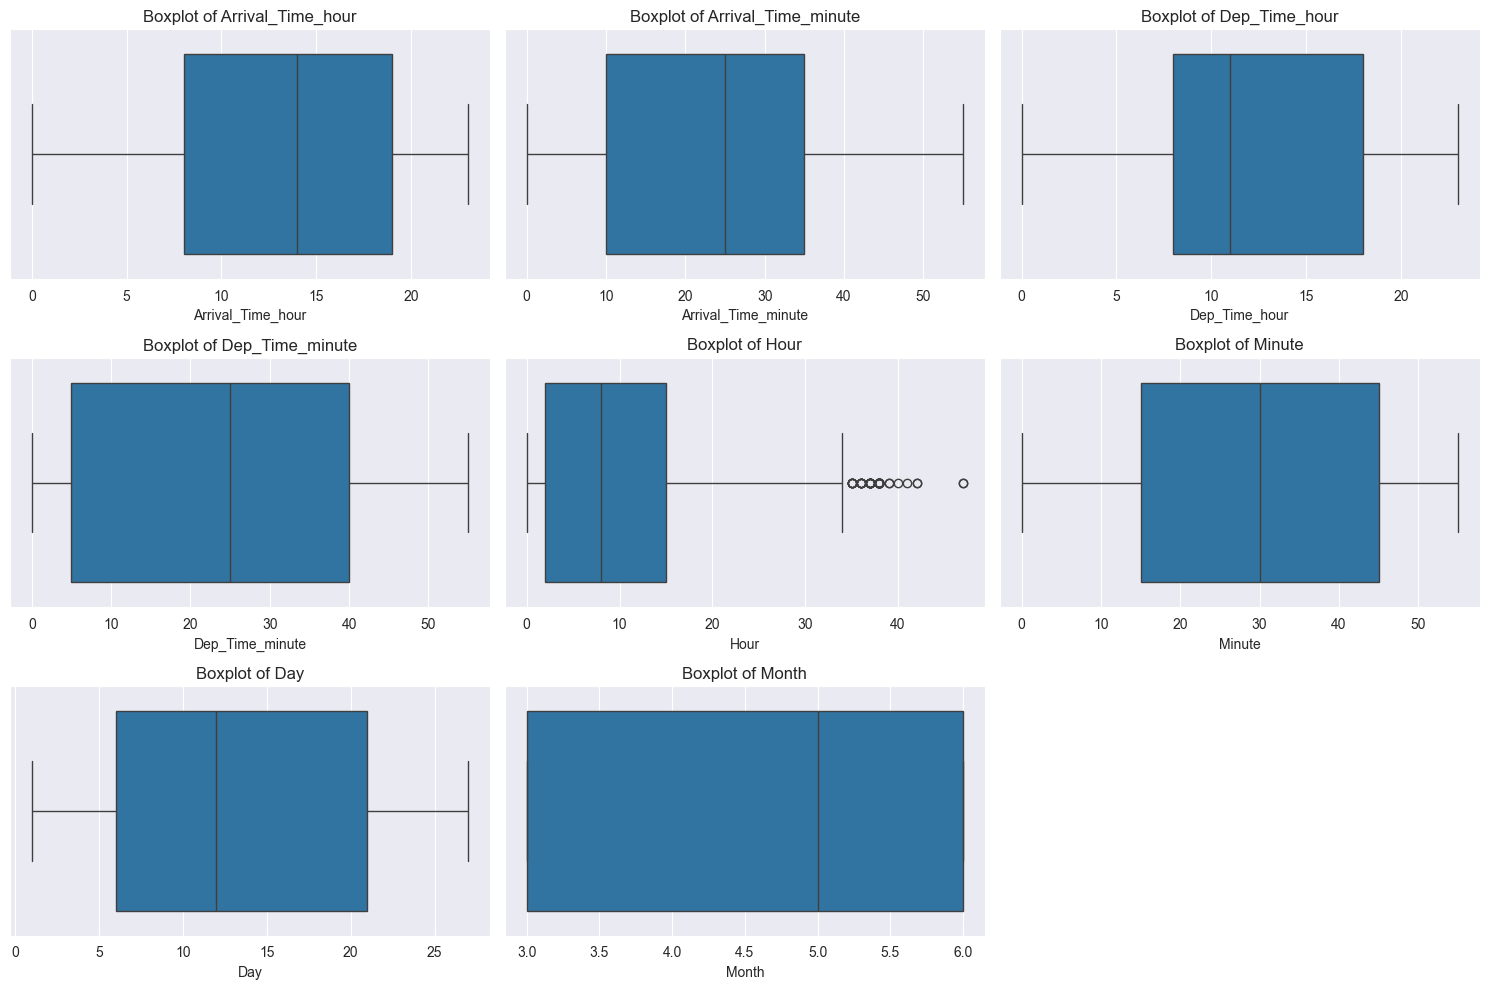

In [58]:
# Select the numerical columns
numerical_cols = ['Arrival_Time_hour', 'Arrival_Time_minute', 'Dep_Time_hour', 
                  'Dep_Time_minute', 'Hour', 'Minute', 'Day', 'Month']

# Plot boxplots for each numerical feature
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


In [61]:
long_flights = df[df['Hour'] > 20]
print(f"Number of long flights (duration > 20 hours): {len(long_flights)}")

# Show sample long-haul flights
long_flights[['Airline', 'Route', 'Total_Stops', 'Hour', 'Minute', 'Price']].head()

Number of long flights (duration > 20 hours): 1799


,Airline,Route,Total_Stops,Hour,Minute,Price
7,4,5,0,21,5,22270
8,4,5,0,25,30,11087
15,1,97,1,26,35,14011
17,4,104,0,22,35,10262
18,1,105,1,23,0,13381


## Splitting and Scaling Data

In [52]:
# Define the feature matrix and target
X = df.drop(['Price'], axis=1)  # Assuming 'Price' is the target variable
y = df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling completed successfully!")

Scaling completed successfully!


In [55]:
# Train the RandomForest model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = regressor.predict(X_test_scaled)

In [56]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 645.8335840278241
Mean Squared Error (MSE): 2942215.0201298236
R² Score: 0.8609799783089247


## Airfare Prediction (Classification)


In [53]:
X_airfare = df.drop(['Price'], axis=1)
y_airfare = df['Price']

X_train_airfare, X_test_airfare, y_train_airfare, y_test_airfare = train_test_split(X_airfare, y_airfare, test_size=0.2, random_state=42)

airfare_model = RandomForestClassifier()
airfare_model.fit(X_train_airfare, y_train_airfare)

KeyboardInterrupt: 